# Download and Create Landsat 8 dataset using rasterio

The Landsat 8 satellite orbits the the Earth in a sun-synchronous, near-polar orbit, at an altitude of 705 km (438 mi) and circles the Earth every 99 minutes.  The satellite has a 16-day repeat cycle with an equatorial crossing time: 10:00 a.m. +/- 15 minutes.  

Landsat 8 data are acquired on the Worldwide Reference System-2 (WRS-2) path/row system.

The scene size for landsat 8 is 170 km x 185 km (106 mi x 115 mi). 



In [27]:
import os
import json
import rasterio
import requests
import matplotlib.pyplot as plt
import numpy as np


## Data source
The data has been downloaded from USGS earth explorer.
The “c1” refers to Collection 1, the “L8” refers to Landsat 8, “139” refers to the scene’s path, “045” refers to the scene’s row, and the final directory matches the product’s identifier, which uses the following naming convention: LXSS_LLLL_PPPRRR_YYYYMMDD_yyymmdd_CC_TX, in which:

L = Landsat
X = Sensor
SS = Satellite
PPP = WRS path
RRR = WRS row
YYYYMMDD = Acquisition date
yyyymmdd = Processing date
CC = Collection number
TX = Collection category
In this case, the scene was taken on 23rd March, 2020.


Inside each directory, GeoTiff images of different band are available and also the metadata in .txt format. 

The Landsat 8 bands are:

| Band                                  |
|---------------------------------------|
| Band 1 - coastal aerosol              |
| Band 2 - blue                         |
| Band 3 - green                        |
| Band 4 - red                          |
| Band 5 - Near Infrared (NIR)          |
| Band 6 - Short-wave Infrared (SWIR) 1 |
| Band 7 - Short-wave Infrared (SWIR) 2 |
| Band 8 - Panchromatic                 |
| Band 9 - Cirrus                       |
| Band 10 - TIRS 1                      |
| Band 11 - TIRS 2                      |


## Process images using rasterio - Study the data

Let us open the two images we downloaded, usin rasterio. The returned object is a **DatasetReader** object. It holds a lot of meta data related to the image. Some of the parameters provide good insights to the task in hand.

### Tiled
Is the data tiled? 

In [28]:
# Reference - https://rasterio.readthedocs.io/en/stable/quickstart.html
reader_red = rasterio.open('red.TIF')
print(reader_red.is_tiled)

reader_nir = rasterio.open('nir.TIF')
print(reader_nir.is_tiled)

False
False


### How many Bands are there in the image?

In [29]:
reader_red.count

1

We downloaded the red band. The count confirms that the image has only one band in it.

### What is the  size of each block (tile itself, as per my understanding) ?

In [30]:
reader_red.block_shapes

[(1, 7651)]

### What is the size of the band image?

In [31]:
print(reader_red .width)
print(reader_red.height)


7651
7801


The dataset reader profile will give all these details in a comprehensive dict of values.

In [32]:
reader_red.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7651, 'height': 7801, 'count': 1, 'crs': CRS.from_dict(init='epsg:32646'), 'transform': Affine(30.0, 0.0, 276885.0,
       0.0, -30.0, 2673015.0), 'tiled': False, 'interleave': 'band'}

## The bounding box

The bounds option will show the spatial reference. Every pixel in the raster image is inside a rectangular bounding box in the world. The landsat image below covers the world from 276885 meters to 506415 meters left to right and 2673015.0 meters to 2438985 meters top to bottom.

In [33]:
reader_red.bounds

BoundingBox(left=276885.0, bottom=2438985.0, right=506415.0, top=2673015.0)

The above bounds can also be derived from an affine transform matrix, as shown below. An affine transformation preserves the collinearity between two points and ratios of distances. It doesn't preserve the angles though. ( Refer - http://mathworld.wolfram.com/AffineTransformation.html ).


In [34]:
reader_red.transform

Affine(30.0, 0.0, 276885.0,
       0.0, -30.0, 2673015.0)

This matrix can be used to find the mapping between pixel position in the image and (x,y) coordinate on the ground. Simply multiply the pizel position by the affine matrix. For example, 
the top,left corner of the bounding box can be calculated by multiplying the transformatiom matrix with (0,0)

In [35]:
reader_red.transform * (0, 0)

(276885.0, 2673015.0)

In [36]:
#Find the (x,y) coordinate of bottm right corner
reader_red.transform * (reader_red.width, reader_red.height)

(506415.0, 2438985.0)

What is the reference point from which these meters are measured? The answer is CRS - coordinate reference system. Our file uses EPSG for the coordinate reference. 

In [37]:
reader_red.crs

CRS.from_dict(init='epsg:32646')

EPSG:32646
WGS 84 / UTM zone 46N
Scope: Large and medium scale topographic mapping and engineering survey.

Area of use: Between 90°E and 96°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. Indonesia. Mongolia. Myanmar (Burma). Russian Federation.

Coordinate system: Cartesian 2D CS. Axes: easting, northing (E,N). Orientations: east, north. UoM: m.
SimpleMap
Center coordinates
500000.00 4649776.22
Projected bounds:
166021.44 0.00
534994.66 9329005.18
WGS84 bounds:
90.0 0.0
96.0 84.0

Between 90°E and 96°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. Indonesia. Mongolia. Myanmar (Burma). Russian Federation.

In [38]:
#import xarray as xr
#red = xr.open_rasterio('data/red.tif', chunks={'band': 1, 'x': 512, 'y': 512})
#red = xr.open_rasterio('data/red.tif', chunks={'band': 1, 'x': 1024, 'y': 1024})
#nir = xr.open_rasterio('data/nir.tif', chunks={'band': 1, 'x': 1024, 'y': 1024})
#print(red)
#print(red.variable.data)

In [39]:
red = reader_red.read(1) # 1 is the band number. 
#If there were more than one band, they could be accessed by changing the number.
nir = reader_nir.read(1)

## spatial coordinates to row-column and vice versa

For this, let us go back to the bounding box. Use the top, left, right, bottom attributes along with 
offsets to specify the geospatial coordinate for a point. Then, use index() method to convert this coordinate to the row and column of the raster data matrix, as shown:


In [40]:
x, y = (reader_red.bounds.left + 100000, reader_red.bounds.top - 50000)
row, col = reader_red.index(x, y)
print(row, col)
red[row, col]

1666 3333


8620

In reverse, to convert one (row, column) of the raster matrix to the geospatial(x,y), call the xy() function.

In [41]:
row, col = (0,0) #very first pixel in the image.
x, y = reader_red.xy(row, col)
x,y

(276900.0, 2673000.0)

## Visualizing

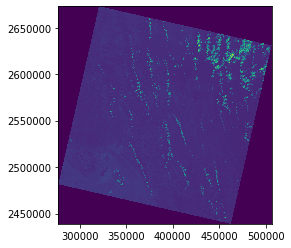

Text(0, 0.5, 'Row #')

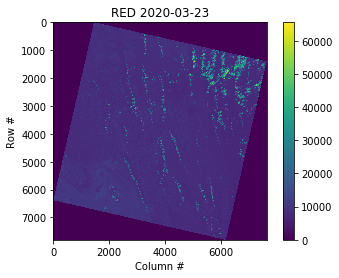

In [42]:
from rasterio.plot import show # import the show function which allows us to display the image

#print("Image dimensions: ", img.shape)
show(red, transform=reader_red.transform)
date = '2020-03-23'
plt.imshow(red)
plt.colorbar()
plt.title('RED {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

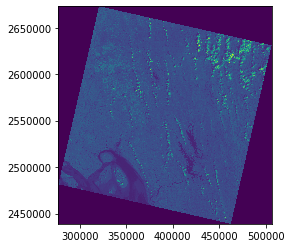

Text(0, 0.5, 'Row #')

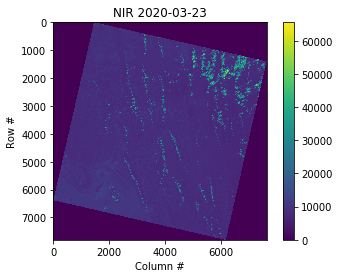

In [43]:
show(nir, transform=reader_nir.transform)
date = '2020-03-23'
plt.imshow(red)
plt.colorbar()
plt.title('NIR {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

## Calculate NDVI using NIR and Red Bands

In [44]:
ndvi = (nir.astype(float) - red.astype(float)) / (nir.astype(float) + red.astype(float))
#ndvi=np.where((nir+red) == 0, 0, (nir.astype(float) - red.astype(float)) / (nir.astype(float) + red.astype(float))
#)

c:\users\sdsou\.conda\envs\new\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Row #')

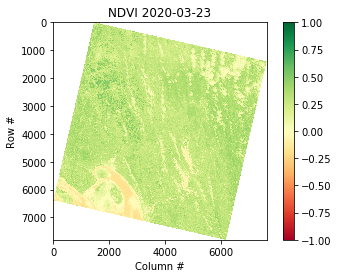

In [45]:
#show(ndvi, transform=reader_red.transform, cmap='RdYlGn')
#input the date
date = '2020-03-23'
#ndvi2d = ndvi.squeeze()
plt.figure()
#im = ndvi2d.compute().plot.imshow( vmin=-1, vmax=1,cmap='RdYlGn')
plt.imshow(ndvi, vmin=-1, vmax=1, cmap='RdYlGn')
#plt.axis('equal')
#plt.show()
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

## NDVI After Atmospheric correction

Let us try calculating NDVI after removing the atmospheric reflection.

In [46]:
def load_scale_factors(filename, band_number):
    with open(filename) as f:
        data = f.read()
        #print(data)
        # metadata = json.dump(data)
        ''' M_p = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_MULT_BAND_{}'.format(band_number)]
            A_p = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_ADD_BAND_{}'.format(band_number)]
         '''
        #hard cording the above values from the meta data file for now
        M_p = 2.0000E-05
        A_p = -0.100000
    return M_p, A_p
def calculate_reflectance(ds, band_number, metafile='LC08_L1TP_138043_20190130_20190206_01_T1_MTL.txt'):
    M_p, A_p = load_scale_factors(metafile, band_number)
    toa = M_p * ds + A_p
    return toa


In [47]:
red_toa = calculate_reflectance(red, band_number=4)
nir_toa = calculate_reflectance(nir, band_number=5)


c:\users\sdsou\.conda\envs\new\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0, 0.5, 'Row #')

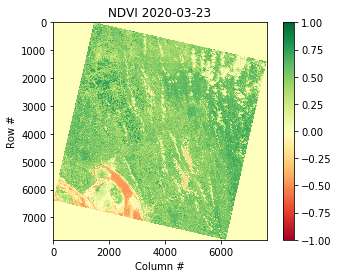

In [48]:
#Calculate NDVI Again
ndvi = (nir_toa - red_toa) / (nir_toa + red_toa)
#ndvi2d = ndvi.squeeze()
plt.figure()
#im = ndvi2d.compute().plot.imshow( vmin=-1, vmax=1,cmap='RdYlGn')
plt.imshow(ndvi, vmin=-1, vmax=1, cmap='RdYlGn')
#plt.axis('equal')
#plt.show()
#input the date
date = '2020-03-23'
#ndvi2d = ndvi.squeeze()
#plt.axis('equal')
#plt.show()
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')